In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dotenv import load_dotenv
from nixtla import NixtlaClient
from statsmodels.tsa.arima.model import ARIMA
from utilsforecast.losses import mae, smape
from utilsforecast.evaluation import evaluate

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['font.size'] = 14 
plt.rcParams['axes.labelsize'] = 14  
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 14 
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[
    "#000072", # blue (for historical data)
    "#80c21d", # green (for actual data)
    "#924eae", # purple
    "#ff0000", # red
    "#ff9100", # orange
])

In [3]:
# Westbound traffic volume on the I-94 between Minneapolis and St-Paul in Minnesota, starting on September 29, 2016, at 5pm
traffic_df = pd.read_csv('../data/hourly_traffic.csv', parse_dates=['date_time'])

# Minimum daily temperature in a city in Australia during the entire year of 1981
temp_df = pd.read_csv('../data/daily_min_temp.csv', parse_dates=['Date'])

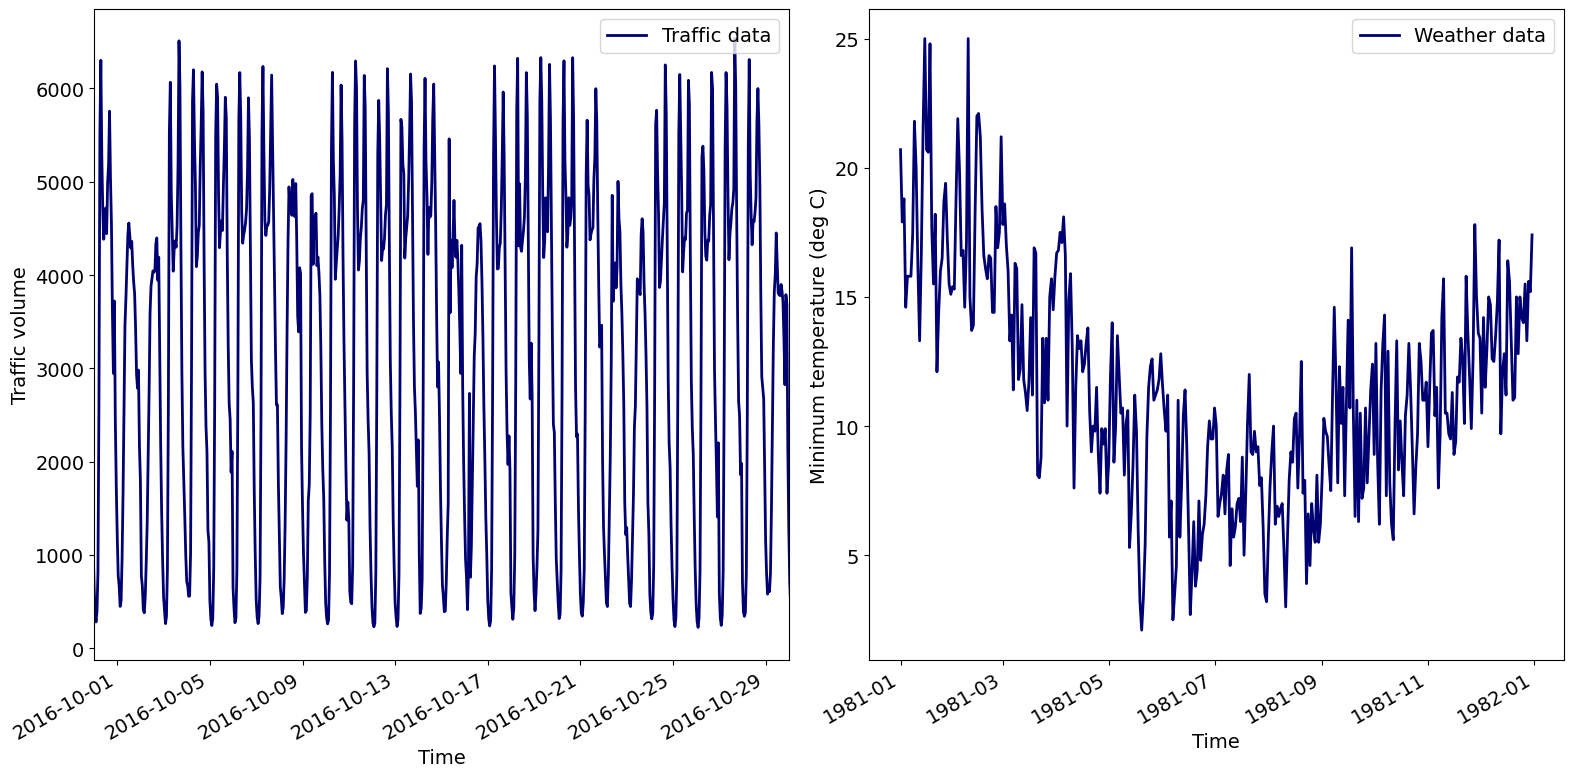

In [6]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,8), sharex=False)

ax1.plot(traffic_df['date_time'], traffic_df['traffic_volume'], label='Traffic data')
ax1.set_xlabel('Time')
ax1.set_ylabel('Traffic volume')
ax1.set_xlim([datetime.date(2016, 9, 30), datetime.date(2016, 10, 30)])
ax1.legend(loc=1)

ax2.plot(temp_df['Date'], temp_df['Temp'], label='Weather data')
ax2.set_xlabel('Time')
ax2.set_ylabel('Minimum temperature (deg C)')
ax2.legend(loc=1)
ax2.tick_params(axis='both', which='both')

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH03_F02_peixeiro2.png', dpi=300)
plt.savefig('figures/CH03_F02_peixeiro2.pdf', format='pdf', bbox_inches='tight')

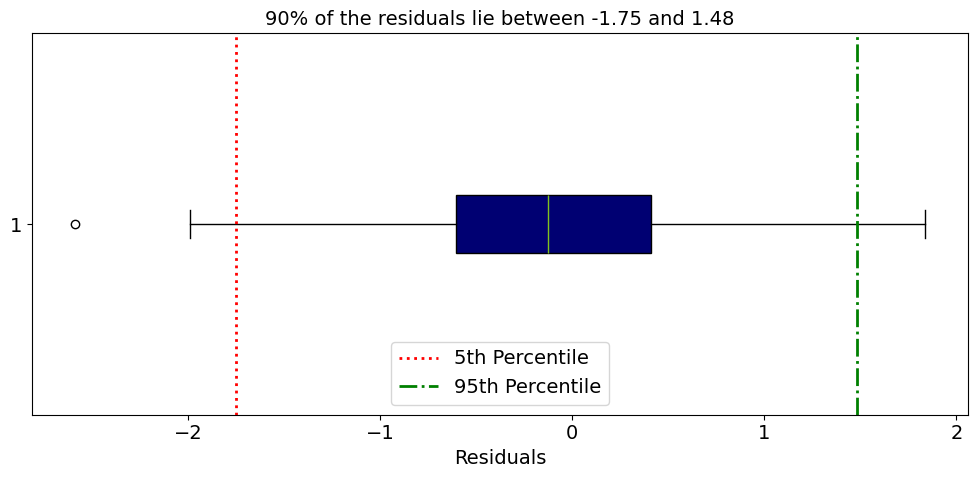

In [7]:
# Generate a time series dataset
np.random.seed(42)
n = 100
time_series_data = np.cumsum(np.random.normal(0, 1, n))

# Fit ARIMA model
model = ARIMA(time_series_data, order=(1, 1, 1))
fitted_model = model.fit()

# Get the residuals
residuals = fitted_model.resid

# Get the 5th and 95th percentiles
lower_bound = round(np.percentile(residuals, 5),2)
upper_bound = round(np.percentile(residuals, 95),2)

# Plot residuals
plt.figure(figsize=(10, 5))
plt.boxplot(residuals, vert=False, patch_artist=True)
plt.title(f'90% of the residuals lie between {lower_bound} and {upper_bound}')
plt.xlabel('Residuals')
plt.axvline(lower_bound, color='red', linestyle=':', label='5th Percentile')
plt.axvline(upper_bound, color='green', linestyle='-.', label='95th Percentile')
plt.legend()
plt.tight_layout()

plt.savefig('figures/CH03_F05_peixeiro2.png', dpi=300)
plt.savefig('figures/CH03_F05_peixeiro2.pdf', format='pdf', bbox_inches='tight')

## Forecasting with TimeGPT

In [8]:
df = pd.read_csv('../data/walmart_sales_small.csv', parse_dates=['Date'])
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106


In [9]:
load_dotenv()

True

In [10]:
nixtla_client = NixtlaClient()

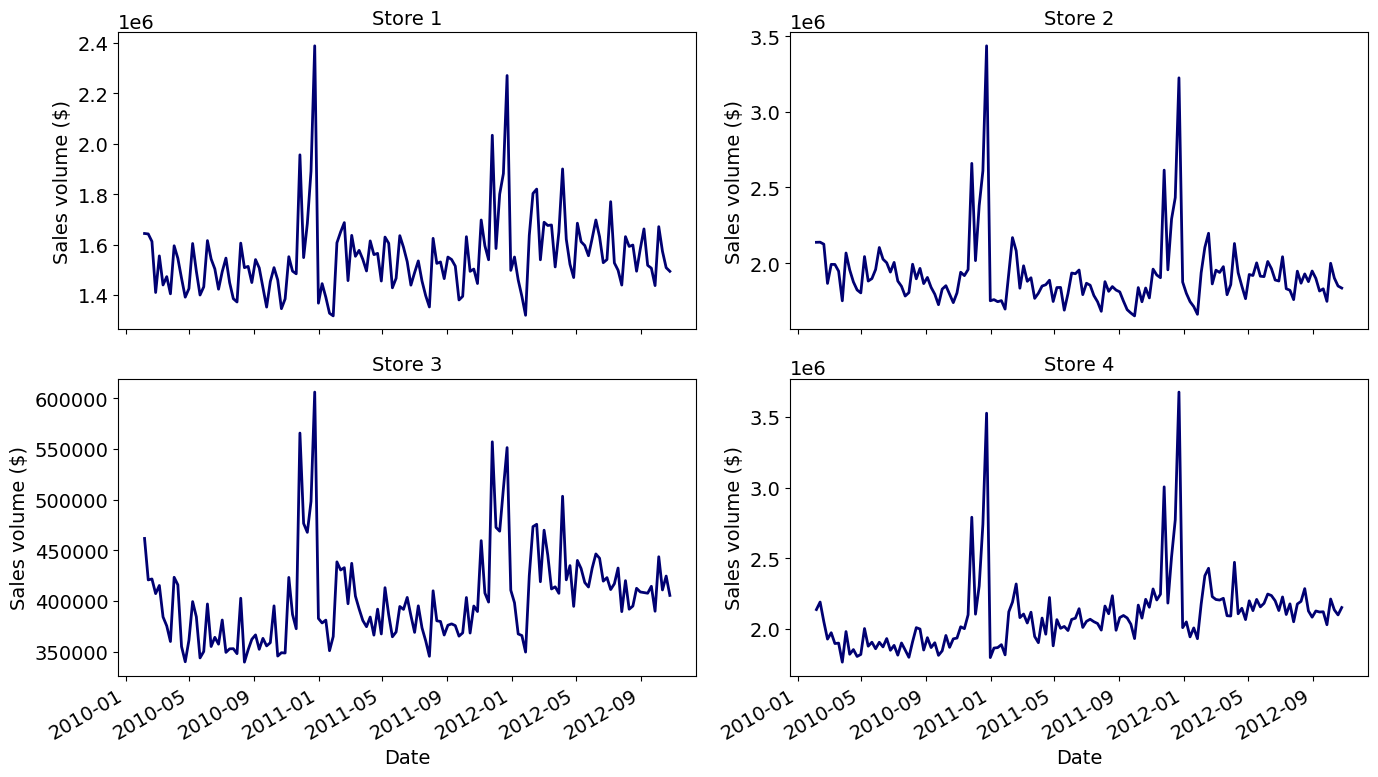

In [11]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(14,8))

for i, ax in enumerate(axes.flatten()):
    store_id = i+1
    data = df.query("Store == @store_id")
    
    ax.plot(data['Date'], data['Weekly_Sales'])
    ax.set_title(f"Store {store_id}")
    ax.set_xlabel('Date')
    ax.set_ylabel('Sales volume ($)')

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH03_F07_peixeiro2.png', dpi=300)
plt.savefig('figures/CH03_F07_peixeiro2.pdf', format='pdf', bbox_inches='tight')

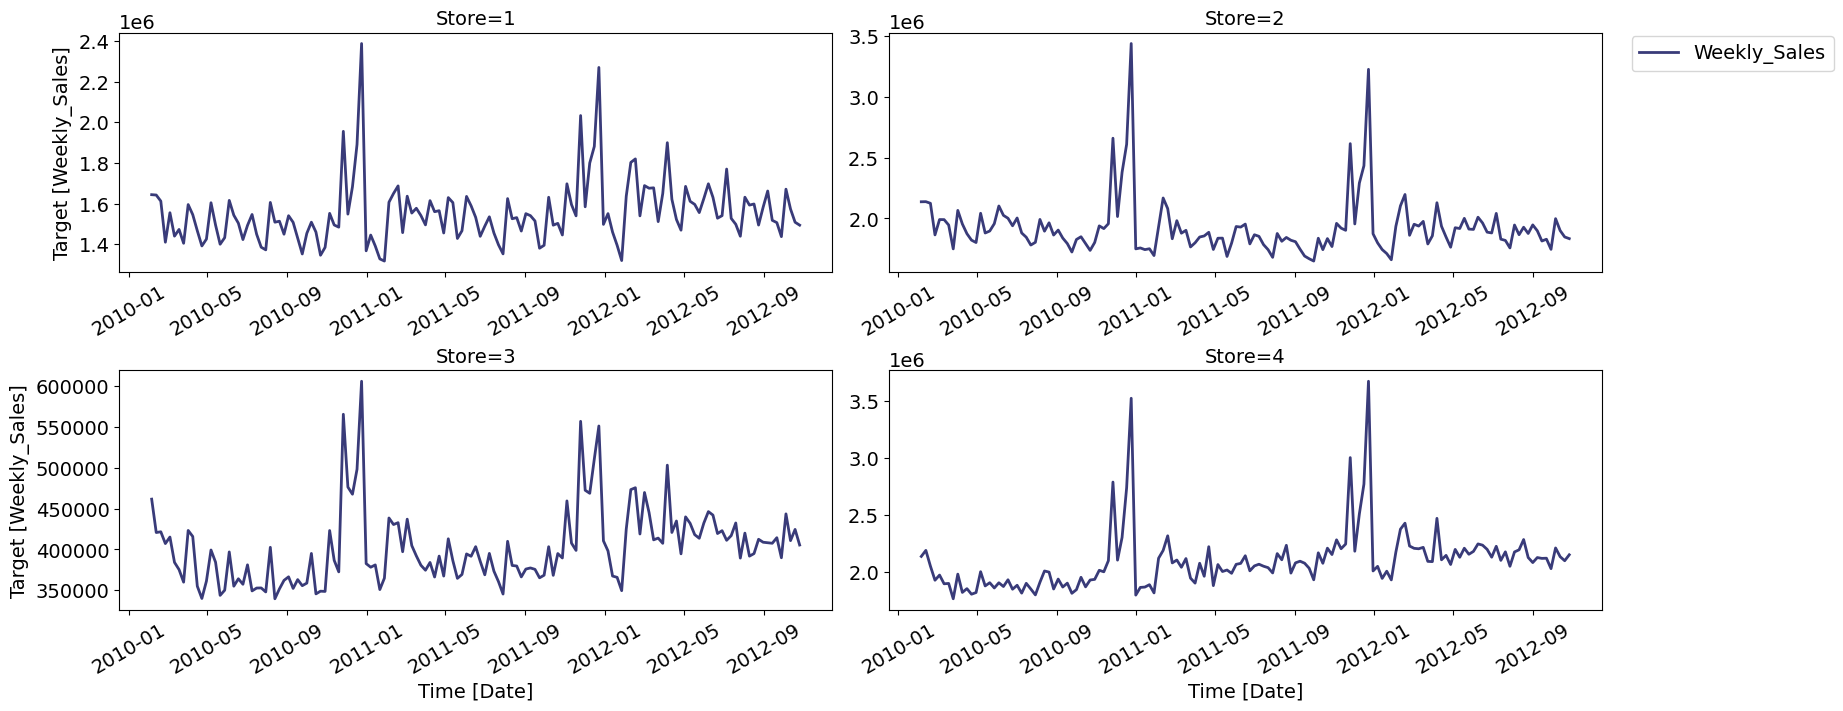

In [12]:
nixtla_client.plot(
    df, 
    time_col='Date', 
    id_col='Store', 
    target_col='Weekly_Sales'
)

In [13]:
preds_df = nixtla_client.forecast(
    df,
    h=8,
    level=[80],
    time_col='Date',
    id_col='Store',
    target_col='Weekly_Sales'
)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: W-FRI
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


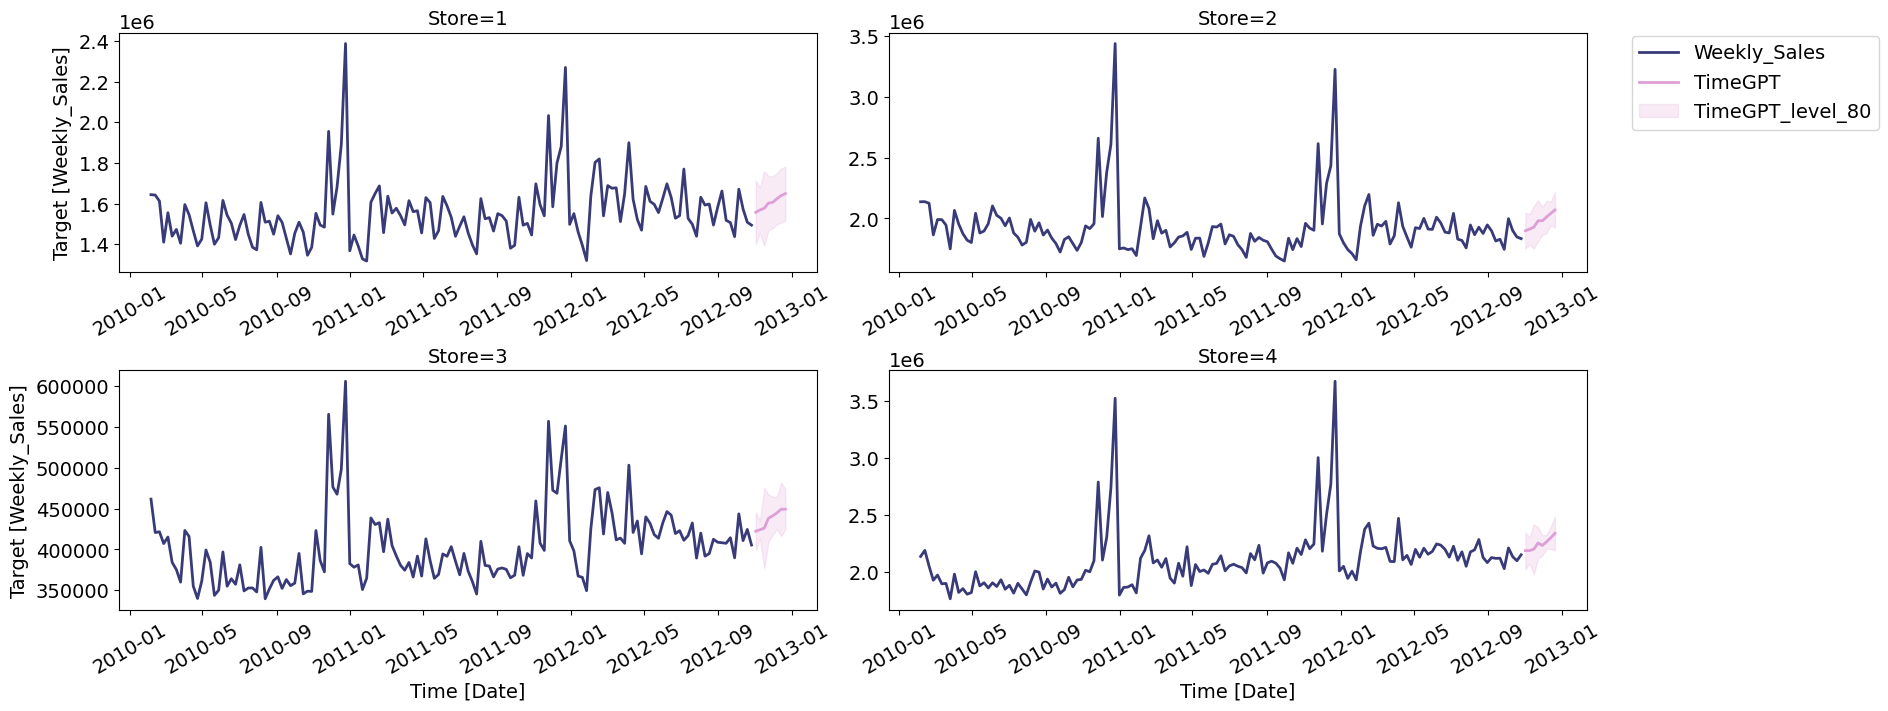

In [14]:
nixtla_client.plot(
    df, 
    preds_df, 
    level=[80], 
    time_col='Date', 
    id_col='Store', 
    target_col='Weekly_Sales'
)

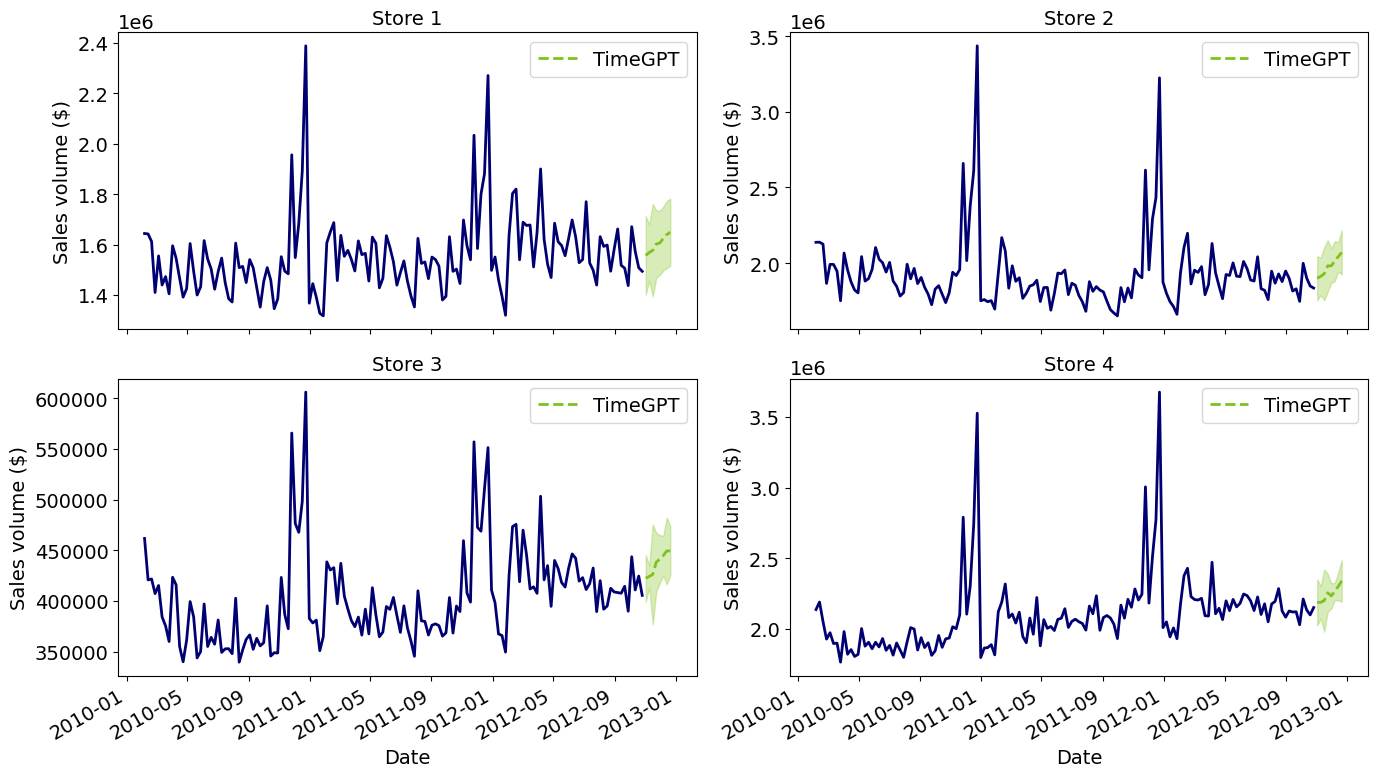

In [15]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(14,8))

for i, ax in enumerate(axes.flatten()):
    store_id = i+1
    data = df.query("Store == @store_id")
    pred_data = preds_df.query("Store == @store_id")
    
    ax.plot(data['Date'], data['Weekly_Sales'])
    ax.plot(pred_data['Date'], pred_data['TimeGPT'], ls='--', color='#80c21d', label='TimeGPT')
    ax.fill_between(pred_data['Date'], pred_data['TimeGPT-lo-80'], pred_data['TimeGPT-hi-80'], color="#80c21d", alpha=0.3)
    
    ax.set_title(f"Store {store_id}")
    ax.set_xlabel('Date')
    ax.set_ylabel('Sales volume ($)')
    ax.legend(loc=1)

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig("figures/CH03_F08_peixeiro2.png", dpi=300)
plt.savefig('figures/CH03_F08_peixeiro2.pdf', format='pdf', bbox_inches='tight')

### Evaluate performance

In [16]:
test_df = df.groupby('Store').tail(8)
input_df = df.drop(test_df.index).reset_index(drop=True)

In [17]:
preds = nixtla_client.forecast(
    input_df,
    h=8,
    level=[80],
    time_col='Date',
    id_col='Store',
    target_col='Weekly_Sales'
)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: W-FRI
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


In [18]:
eval_df = test_df.copy()

preds['Date'] = pd.to_datetime(preds['Date'])

eval_df = pd.merge(eval_df, preds, 'left', ['Store', 'Date'])

In [19]:
evaluation = evaluate(
    eval_df,
    metrics=[mae, smape],
    models=['TimeGPT'],
    target_col='Weekly_Sales',
    id_col='Store'
)

avg_metrics = evaluation.groupby('metric')['TimeGPT'].mean()

avg_metrics

metric
mae      54057.343437
smape        0.017555
Name: TimeGPT, dtype: float64

### Fine-tuning TimeGPT

In [20]:
sub_df = df[df['Store'] == 1]

test_df = sub_df.tail(8)
input_df = sub_df.drop(test_df.index).reset_index(drop=True)

In [21]:
preds = nixtla_client.forecast(
    df=input_df,
    h=8,
    time_col='Date',
    id_col='Store',
    target_col='Weekly_Sales'
)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: W-FRI
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


In [20]:
finetune_preds = nixtla_client.forecast(
    df=input_df,
    h=8,
    finetune_steps=10,
    finetune_loss='mae',
    time_col='Date',
    id_col='Store',
    target_col='Weekly_Sales'
)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: W-FRI
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


In [21]:
eval_df = test_df[['Store', 'Date', 'Weekly_Sales']]

finetune_preds.rename(columns={"TimeGPT": "TimeGPT-finetuned"}, inplace=True)

eval_df = pd.merge(eval_df, finetune_preds, 'left', ['Store', 'Date'])
eval_df = pd.merge(eval_df, preds, 'left', ['Store', 'Date'])

eval_df.head()

,Store,Date,Weekly_Sales,TimeGPT-finetuned,TimeGPT
0,1,2012-09-07,1661767.33,1558124.2,1562177.9
1,1,2012-09-14,1517428.87,1560675.1,1559482.6
2,1,2012-09-21,1506126.06,1549928.5,1544988.6
3,1,2012-09-28,1437059.26,1553688.6,1556686.0
4,1,2012-10-05,1670785.97,1576523.5,1586022.5


In [22]:
evaluation = evaluate(
    eval_df,
    metrics=[mae, smape],
    models=['TimeGPT', 'TimeGPT-finetuned'],
    target_col='Weekly_Sales',
    id_col='Store'
)

evaluation

,Store,metric,TimeGPT,TimeGPT-finetuned
0,1,mae,75237.336250,70822.011250
1,1,smape,0.024143,0.022763


In [23]:
finetune_depth_preds = nixtla_client.forecast(
    df=input_df,
    h=8,
    finetune_steps=10,
    finetune_depth=2,
    finetune_loss='mae',
    time_col='Date',
    id_col='Store',
    target_col='Weekly_Sales'
)

finetune_depth_preds.rename(columns={"TimeGPT": "TimeGPT-finetuned-depth"}, inplace=True)
eval_df = pd.merge(eval_df, finetune_depth_preds, 'left', ['Store', 'Date'])

evaluation = evaluate(
    eval_df,
    metrics=[mae, smape],
    models=['TimeGPT', 'TimeGPT-finetuned', 'TimeGPT-finetuned-depth'],
    target_col='Weekly_Sales',
    id_col='Store'
)

evaluation

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: W-FRI
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


,Store,metric,TimeGPT,TimeGPT-finetuned,TimeGPT-finetuned-depth
0,1,mae,75237.336250,70822.011250,63544.438750
1,1,smape,0.024143,0.022763,0.020409


### Forecasting with exogenous variables

In [24]:
future_exog = test_df[['Store', 'Date', 'Holiday_Flag']]
future_exog

,Store,Date,Holiday_Flag
135,1,2012-09-07,1
136,1,2012-09-14,0
137,1,2012-09-21,0
138,1,2012-09-28,0
139,1,2012-10-05,0
140,1,2012-10-12,0
141,1,2012-10-19,0
142,1,2012-10-26,0


#### Forecast fuel price and CPI

In [25]:
fuel_preds = nixtla_client.forecast(
    df=input_df,
    h=8,
    time_col='Date',
    id_col='Store',
    target_col='Fuel_Price'
)
fuel_preds.rename(columns={"TimeGPT": "Fuel_Price"}, inplace=True)

cpi_preds = nixtla_client.forecast(
    df=input_df,
    h=8,
    time_col='Date',
    id_col='Store',
    target_col='CPI'
)
cpi_preds.rename(columns={"TimeGPT": "CPI"}, inplace=True)

fuel_preds['Date'] = pd.to_datetime(finetune_preds['Date'])
cpi_preds['Date'] = pd.to_datetime(finetune_preds['Date'])

future_exog = pd.merge(future_exog, fuel_preds, 'left', ['Store', 'Date'])
future_exog = pd.merge(future_exog, cpi_preds, 'left', ['Store', 'Date'])

future_exog

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: W-FRI
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: W-FRI
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


,Store,Date,Holiday_Flag,Fuel_Price,CPI
0,1,2012-09-07,1,3.612594,222.32915
1,1,2012-09-14,0,3.597838,222.33977
2,1,2012-09-21,0,3.555918,222.39162
3,1,2012-09-28,0,3.487907,222.55237
4,1,2012-10-05,0,3.454414,222.74560
5,1,2012-10-12,0,3.455894,222.82834
6,1,2012-10-19,0,3.466672,222.90556
7,1,2012-10-26,0,3.468813,222.98392


In [26]:
preds_exog = nixtla_client.forecast(
    df=input_df,
    X_df=future_exog,
    h=8,
    finetune_steps=10,
    finetune_depth=2,
    finetune_loss='mae',
    time_col='Date',
    id_col='Store',
    target_col='Weekly_Sales',
    feature_contributions=True
)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: W-FRI
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using future exogenous features: ['Holiday_Flag', 'Fuel_Price', 'CPI']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


In [27]:
exog_shap = nixtla_client.feature_contributions
exog_shap.head()

,Store,Date,TimeGPT,Holiday_Flag,Fuel_Price,CPI,base_value
0,1,2012-09-07,1564451.8,0.0,-6043.0366,40984.727,1529510.0
1,1,2012-09-14,1557441.4,0.0,-6043.0366,40984.727,1522499.6
2,1,2012-09-21,1549763.0,0.0,-6043.0366,40984.727,1514821.2
3,1,2012-09-28,1554451.1,0.0,-7291.4087,42233.100,1519509.4
4,1,2012-10-05,1567414.4,0.0,-16303.6430,51245.332,1532472.6


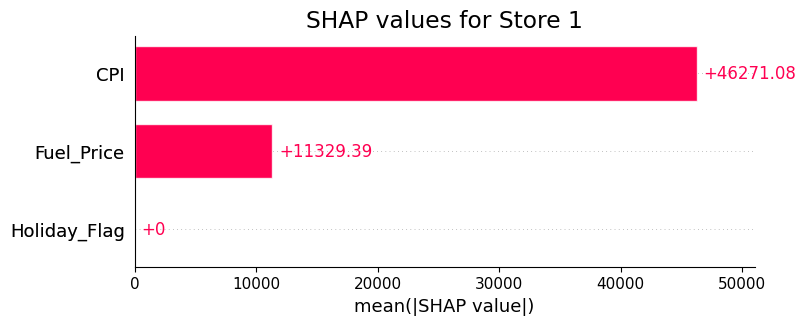

<Figure size 640x480 with 0 Axes>

In [28]:
import shap

shap_columns = exog_shap.columns.difference(['Store', 'Date', 'TimeGPT', 'base_value'])
shap_values = exog_shap[shap_columns].values
base_values = exog_shap['base_value'].values
features = shap_columns

shap_obj = shap.Explanation(values=shap_values, base_values=base_values, feature_names=features)

shap.plots.bar(shap_obj, max_display=len(features), show=False)
plt.title(f'SHAP values for Store 1')
plt.show()
plt.savefig("figures/Ch03_codefig05.png", dpi=300)

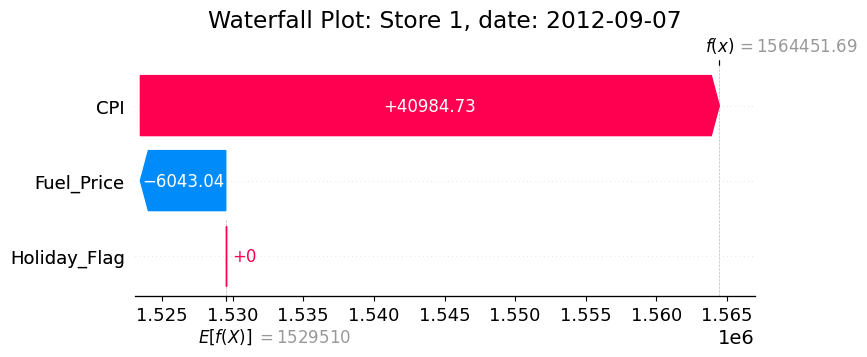

In [29]:
selected_ds = '2012-09-07'

filtered_df = exog_shap[exog_shap['Date'] == selected_ds]

shap_values = filtered_df[shap_columns].values.flatten()
base_value = filtered_df['base_value'].values[0]
features = shap_columns

shap_obj = shap.Explanation(values=shap_values, base_values=base_value, feature_names=features)

shap.plots.waterfall(shap_obj, show=False)
plt.title(f'Waterfall Plot: Store 1, date: {selected_ds}')
plt.show()
plt.savefig("figures/Ch03_codefig06.png", dpi=300)

In [30]:
preds_exog.rename(columns={"TimeGPT": "TimeGPT-exog"}, inplace=True)
eval_df = pd.merge(eval_df, preds_exog, 'left', ['Store', 'Date'])

evaluation = evaluate(
    eval_df,
    metrics=[mae, smape],
    target_col='Weekly_Sales',
    id_col='Store',
    time_col='Date'
)

evaluation

,Store,metric,TimeGPT-finetuned,TimeGPT,TimeGPT-finetuned-depth,TimeGPT-exog
0,1,mae,70822.011250,75237.336250,63544.438750,67205.488750
1,1,smape,0.022763,0.024143,0.020409,0.021613


In [32]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

x = ['TimeGPT', 'TimeGPT-finetuned', 'TimeGPT-finetuned_depth', 'TimeGPT-exog']
y_mae = [75237, 70822, 63544, 67205]
y_smape = [2.41, 2.28, 2.04, 2.16]

ax1.bar(x, y_mae, width=0.4, label='MAE')
ax1.set_xlabel('Models')
ax1.set_ylabel('MAE ($)')
ax1.legend()

for i, v in enumerate(y_mae):
    ax1.text(x=i, y=v+300, s=str(v), ha='center')

ax2.bar(x, y_smape, width=0.4, label='sMAPE')
ax2.set_xlabel('Models')
ax2.set_ylabel('sMAPE (%)')
ax2.legend()

for i, v in enumerate(y_smape):
    ax2.text(x=i, y=v+.03, s=str(v), ha='center')

fig.autofmt_xdate()
plt.tight_layout()
plt.savefig("figures/CH03_codefig07.png", dpi=300)

### Cross-validation with TimeGPT

In [40]:
cv_df = nixtla_client.cross_validation(
    df=sub_df,
    h=8,
    n_windows=4,
    finetune_steps=10,
    finetune_depth=2,
    finetune_loss='mae',
    time_col='Date',
    id_col='Store',
    target_col='Weekly_Sales'
)

cv_df.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: W-FRI
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using the following exogenous features: ['Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
INFO:nixtla.nixtla_client:Calling Cross Validation Endpoint...


,Store,Date,cutoff,Weekly_Sales,TimeGPT
0,1,2012-03-23,2012-03-16,1511068.07,1641376.6
1,1,2012-03-30,2012-03-16,1649604.63,1638470.5
2,1,2012-04-06,2012-03-16,1899676.88,1644387.8
3,1,2012-04-13,2012-03-16,1621031.70,1628486.8
4,1,2012-04-20,2012-03-16,1521577.87,1615136.5


In [34]:
cutoffs = cv_df['cutoff'].unique()

plt.figure(figsize=(15,5))
plt.plot(sub_df['Date'], sub_df['Weekly_Sales'])
plt.plot(cv_df['Date'], cv_df['TimeGPT'], label='TimeGPT', ls='--')

for cutoff in cutoffs:
    plt.axvline(x=cutoff, color='black', ls=':')

plt.xlabel('Date')
plt.ylabel('Weekly sales')
plt.legend()
plt.tight_layout()
plt.savefig("figures/CH03_codefig08.png", dpi=300)

In [41]:
evaluation = evaluate(
    cv_df,
    metrics=[mae, smape],
    models=['TimeGPT'],
    target_col='Weekly_Sales',
    id_col='Store'
)

evaluation

,Store,metric,TimeGPT
0,1,mae,75178.836562
1,1,smape,0.023524


### Long-horizon forecasting with TimeGPT

In [36]:
test_df = sub_df.tail(52)
input_df = sub_df.drop(test_df.index).reset_index(drop=True)

In [37]:
long_preds = nixtla_client.forecast(
    df=input_df,
    h=52,
    model='timegpt-1-long-horizon',
    time_col='Date',
    id_col='Store',
    target_col='Weekly_Sales'
)
long_preds.rename(columns={"TimeGPT": "TimeGPT-long"}, inplace=True)

short_preds = nixtla_client.forecast(
    df=input_df,
    h=52,
    time_col='Date',
    id_col='Store',
    target_col='Weekly_Sales'
)
short_preds.rename(columns={"TimeGPT": "TimeGPT-short"}, inplace=True)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: W-FRI
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: W-FRI
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


In [38]:
eval_df = test_df[['Store', 'Date', 'Weekly_Sales']]

eval_df = pd.merge(eval_df, long_preds, 'left', ['Store', 'Date'])
eval_df = pd.merge(eval_df, short_preds, 'left', ['Store', 'Date'])

evaluation = evaluate(
    eval_df,
    metrics=[mae, smape],
    models=['TimeGPT-long', 'TimeGPT-short'],
    target_col='Weekly_Sales',
    id_col='Store'
)

evaluation

,Store,metric,TimeGPT-long,TimeGPT-short
0,1,mae,111408.026923,106306.697692
1,1,smape,0.033728,0.032078


In [39]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

x = ['TimeGPT-short', 'TimeGPT-long']
y_mae = [111408, 106306]
y_smape = [3.37, 3.21]

ax1.bar(x, y_mae, width=0.4, label='MAE')
ax1.set_xlabel('Models')
ax1.set_ylabel('MAE ($)')
ax1.legend()

for i, v in enumerate(y_mae):
    ax1.text(x=i, y=v+300, s=str(v), ha='center')

ax2.bar(x, y_smape, width=0.4, label='sMAPE')
ax2.set_xlabel('Models')
ax2.set_ylabel('sMAPE (%)')
ax2.legend()

for i, v in enumerate(y_smape):
    ax2.text(x=i, y=v+.03, s=str(v), ha='center')

plt.tight_layout()
plt.savefig("figures/CH03_codefig09.png", dpi=300)

## Anomaly detection with TimeGPT

In [22]:
df = pd.read_csv('../data/nyc_taxi_anomaly_daily.csv', parse_dates=['timestamp'])
df.head()

,timestamp,value,is_anomaly
0,2014-07-01,745967,0
1,2014-07-02,733640,0
2,2014-07-03,710142,0
3,2014-07-04,552565,0
4,2014-07-05,555470,0


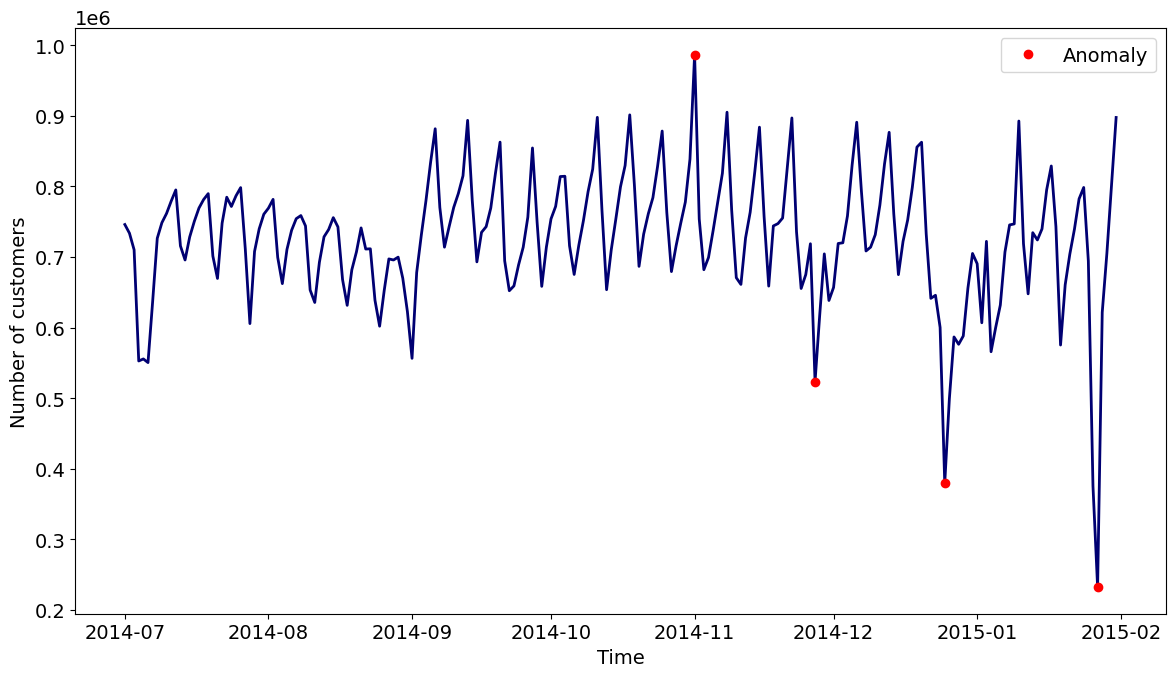

In [24]:
anomaly_df = df.loc[df['is_anomaly'] == 1]

fig, ax = plt.subplots(figsize=(12,7))

ax.plot(df['timestamp'], df['value'])
ax.plot(anomaly_df['timestamp'], anomaly_df['value'], 'o', color='red', label='Anomaly')
ax.set_xlabel('Time')
ax.set_ylabel('Number of customers')
ax.legend(loc='best')

plt.tight_layout()
plt.savefig("figures/CH03_F15_peixeiro2.png", dpi=300)
plt.savefig('figures/CH03_F15_peixeiro2.pdf', format='pdf', bbox_inches='tight')

In [25]:
anomalies_df = nixtla_client.detect_anomalies(
    df[['timestamp', 'value']], 
    time_col='timestamp', 
    target_col='value', 
)
anomalies_df['anomaly'] = anomalies_df['anomaly'].astype(int)
anomalies_df.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: D
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Anomaly Detector Endpoint...


,timestamp,value,TimeGPT,TimeGPT-hi-99,TimeGPT-lo-99,anomaly
0,2014-08-03,699449,689231.30,904585.75,473876.84,0
1,2014-08-04,662215,660703.06,876057.50,445348.60,0
2,2014-08-05,710728,731873.10,947227.56,516518.66,0
3,2014-08-06,737803,764084.94,979439.40,548730.50,0
4,2014-08-07,754260,769902.50,985256.94,554548.06,0


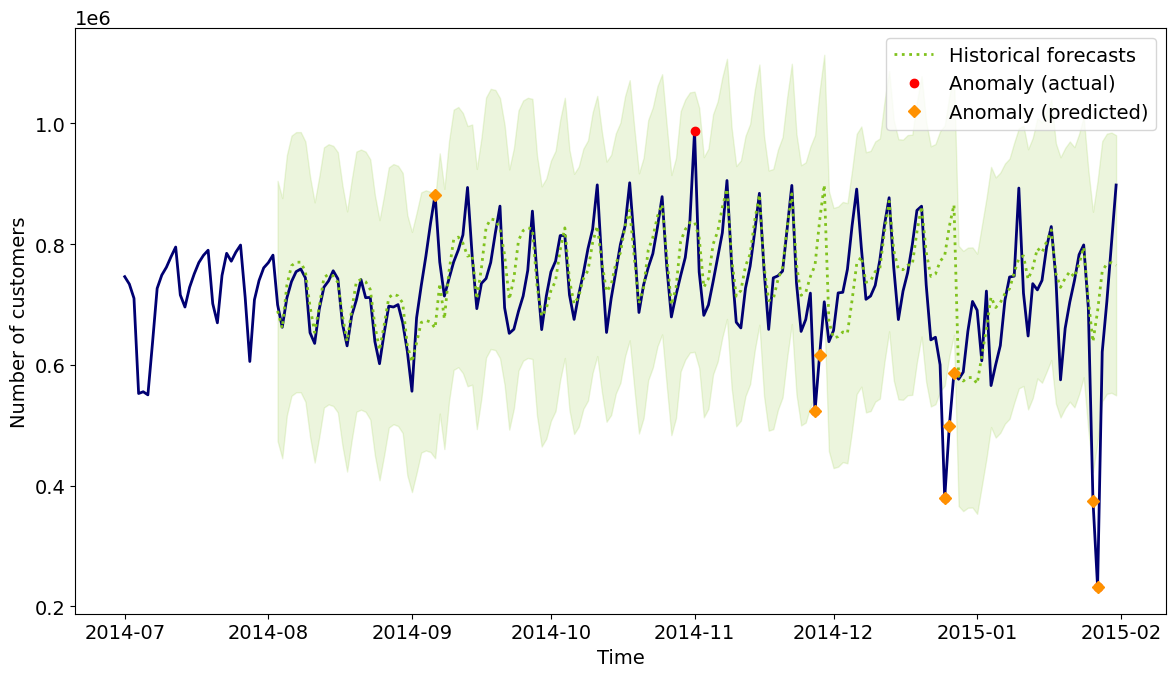

In [26]:
anomaly_df = df.loc[df['is_anomaly'] == 1]
anomaly_preds_df = anomalies_df.loc[anomalies_df['anomaly'] == 1]

fig, ax = plt.subplots(figsize=(12,7))

ax.plot(df['timestamp'], df['value'])
ax.plot(anomalies_df['timestamp'], anomalies_df['TimeGPT'], ls=':', color="#80c21d", label='Historical forecasts')
ax.fill_between(anomalies_df['timestamp'], anomalies_df['TimeGPT-lo-99'], anomalies_df['TimeGPT-hi-99'], color="#80c21d", alpha=0.15)
ax.plot(anomaly_df['timestamp'], anomaly_df['value'], 'o', color='#ff0000', label='Anomaly (actual)')
ax.plot(anomaly_preds_df['timestamp'], anomaly_preds_df['value'], 'D', color='#ff9100', label='Anomaly (predicted)')
ax.set_xlabel('Time')
ax.set_ylabel('Number of customers')
ax.legend(loc='best')

plt.tight_layout()
plt.savefig("figures/CH03_F16_peixeiro2.png", dpi=300)
plt.savefig('figures/CH03_F16_peixeiro2.pdf', format='pdf', bbox_inches='tight')

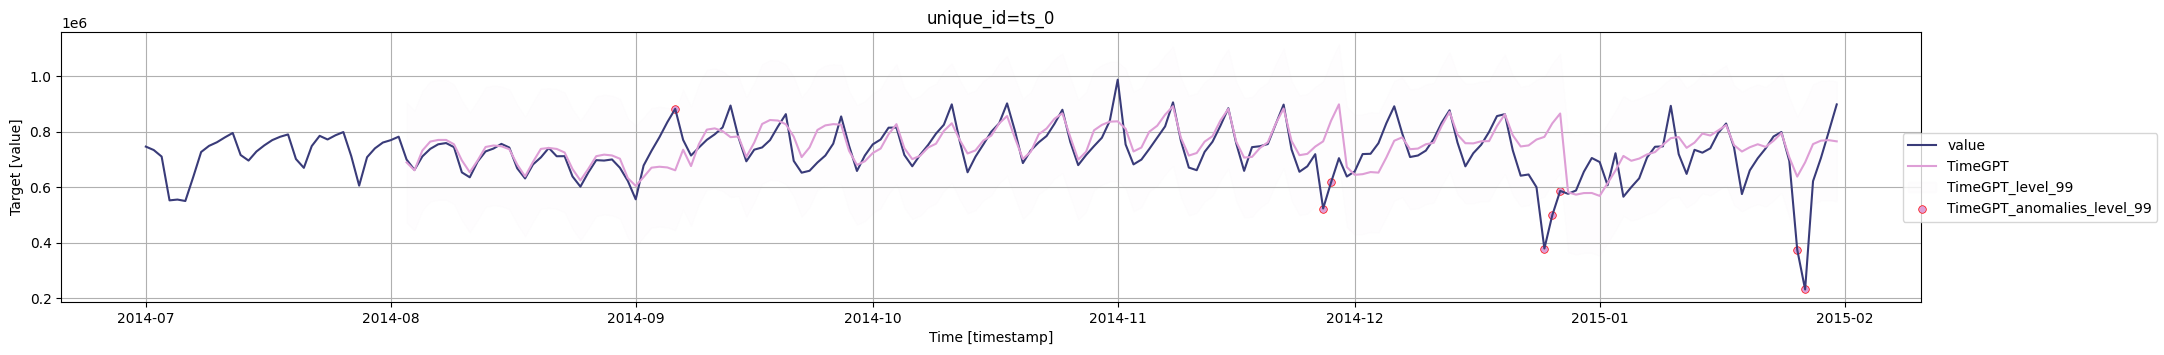

In [17]:
nixtla_client.plot(
    df, 
    anomalies_df,
    level=[99],
    time_col='timestamp', 
    target_col='value'
)

In [69]:
def evaluate_anomaly_detection(df, preds_col, actual_col):
    tp = ((df[preds_col] == 1) & (df[actual_col] == 1)).sum()
    
    tn = ((df[preds_col] == 0) & (df[actual_col] == 0)).sum()
    
    fp = ((df[preds_col] == 1) & (df[actual_col] == 0)).sum()
    
    fn = ((df[preds_col] == 0) & (df[actual_col] == 1)).sum()
    
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    
    return precision, recall, f1_score

In [70]:
anomaly_eval_df = pd.merge(anomalies_df, df, 'left', ['timestamp'])
anomaly_eval_df.head()

,timestamp,value_x,TimeGPT,TimeGPT-hi-99,TimeGPT-lo-99,anomaly,value_y,is_anomaly
0,2014-08-03,699449,689234.94,904590.75,473879.16,0,699449,0
1,2014-08-04,662215,660707.80,876063.60,445352.03,0,662215,0
2,2014-08-05,710728,731871.94,947227.75,516516.16,0,710728,0
3,2014-08-06,737803,764083.94,979439.75,548728.10,0,737803,0
4,2014-08-07,754260,769904.40,985260.20,554548.56,0,754260,0


In [71]:
precision, recall, f1_score = evaluate_anomaly_detection(anomaly_eval_df, 'anomaly', 'is_anomaly')

print(f"Precision: {round(precision,2)}")
print(f"Recall: {round(recall,2)}")
print(f"F1-Score: {round(f1_score,2)}")

Precision: 0.38
Recall: 0.75
F1-Score: 0.5


In [72]:
anomalies_df_90 = nixtla_client.detect_anomalies(
    df,
    level=90,
    time_col='timestamp', 
    target_col='value', 
)

anomaly_eval_df = pd.merge(anomalies_df_90, df, 'left', ['timestamp'])

precision, recall, f1_score = evaluate_anomaly_detection(anomaly_eval_df, 'anomaly', 'is_anomaly')

print(f"Precision: {round(precision,2)}")
print(f"Recall: {round(recall,2)}")
print(f"F1-Score: {round(f1_score,2)}")

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: D
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using the following exogenous features: ['is_anomaly']
INFO:nixtla.nixtla_client:Calling Anomaly Detector Endpoint...


Precision: 0.2
Recall: 0.75
F1-Score: 0.32


In [73]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

x = ['Precision', 'Recall', 'F1-Score']
y_99 = [0.38, 0.75, 0.50]
y_90 = [0.20, 0.75, 0.32]

ax1.bar(x, y_99, width=0.4, label='99% confidence interval')
ax1.set_xlabel('Metrics')
ax1.set_ylabel('Score')
ax1.legend()

for i, v in enumerate(y_99):
    ax1.text(x=i, y=v+0.01, s=str(v), ha='center')

ax2.bar(x, y_90, width=0.4, label='90% confidence interval')
ax2.set_xlabel('Metrics')
ax2.set_ylabel('Score')
ax2.legend()

for i, v in enumerate(y_90):
    ax2.text(x=i, y=v+.01, s=str(v), ha='center')

plt.tight_layout()
plt.savefig("figures/CH03_codefig12.png", dpi=300)